In this notebook we compute the pseudo R2 maps between subtypes and TDC for their later association with the transcriptomics data

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import json
import matplotlib.pylab as plt
import numpy as np
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
from os.path import join as opj
from nilearn import image, plotting

from mdmr import MDMR

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Load the (harmonised) FC data, covariates (age, sex, motion, FIQ) and demographics

In [2]:
data_after_combat = np.load("../results/desikan/data_after_combat_motion_aggressive.npz")

# harmonised FC data
Y_combat = data_after_combat['Y_combat']
print(Y_combat.shape)
n_rois = squareform(Y_combat[0,:], checks=False).shape[1]
n_subjects = Y_combat.shape[0]

# Convert these to connectivity matrices
CC_adjust = np.array([squareform(Y_combat[ii, :], checks=False) + np.eye(n_rois) for ii in range(n_subjects)])
print(CC_adjust.shape)

# Covariates:
age = data_after_combat['age']
sex = data_after_combat['sex']
group = data_after_combat['group']
motion = data_after_combat['motion']

# Get demographics data to extract FIQ to be used as another covariate
subjects = data_after_combat['subjects']
demo_cluster = pd.read_excel("../results/desikan/pheno_w_clusters.xlsx")

# Rearrange demographic data according to subjects in the data
demo_cluster = pd.merge(pd.DataFrame({'SUB_ID': subjects}), demo_cluster, on="SUB_ID")

# Check that this coincides with the subjects previously saved in a previous notebook
np.corrcoef(demo_cluster.SUB_ID.to_numpy(), subjects)

(1541, 3321)
(1541, 82, 82)


array([[1., 1.],
       [1., 1.]])

Prepare target data and input for MDMR

In [3]:
# Covariates: Age, sex, FIQ, FD and DVARS
covariates = ['AGE_AT_SCAN', 'SEX',  'FIQ', "FD_mean", "DVARS_mean"]
# input variables for MDMR: group and subtyping id (variables of interest) + covariates
variables = ['clus_id_euclidean', "DX_GROUP"] + covariates
# Discard any subject with missing info in some of these variables (normally only missing info in FIQ)
to_take = ~np.any(demo_cluster.loc[:, variables].isna(), axis=1).values

# Construct input matrix as data frame
XX_df = demo_cluster.loc[to_take, variables]
# Square (harmonized) connectivity matrices
YY = CC_adjust[to_take, :, :]

# Make some conversions for categorical data

XX_df['clus_id_euclidean'] = XX_df['clus_id_euclidean'].astype(str)
XX_df['SEX'] = XX_df['SEX'].astype(str)
XX_df['DX_GROUP'] = (XX_df['DX_GROUP']==1).astype(int).astype(str)

print("Subtypes (0==TDC)")
print(XX_df['clus_id_euclidean'].value_counts())
print("")

print("Groups")
print(XX_df['DX_GROUP'].value_counts())

Subtypes (0==TDC)
0          835
1          321
2          266
3           21
outlier      2
Name: clus_id_euclidean, dtype: int64

Groups
0    835
1    610
Name: DX_GROUP, dtype: int64


Run MDMR, without computing p-values. We are not using them and in this way we save computational time, given that these are calculated by permutation

In [4]:
# Empty data frames for results
res_F_df_euclidean = pd.DataFrame({})
res_Rsq_df_euclidean = pd.DataFrame({})

X_df = XX_df.loc[:, ["clus_id_euclidean"] + covariates].copy()

# Take only subtype 1 and 2
for jj in [1, 2]:
    print("doing cluster %d" % jj)
    list_Fs = []
    list_Rs = []
    # 0 is TDC, we compare with one of the subtypes
    cond = (X_df.loc[:, "clus_id_euclidean"] =='0') | (X_df.loc[:, "clus_id_euclidean"] ==str(jj))
    
    XX = X_df.loc[cond,:]
    for ii in range(YY.shape[1]):
        
        # Do not consider autocorrelation entries, which are 1
        mask = np.arange(n_rois)!=ii
        
        # Construct matrix distance
        D = squareform(pdist(YY[cond, ii, :][:, mask], 'euclidean'))
        mdmr = MDMR(verbose=0)
        mdmr.fit(XX, D)
        list_Fs.append(mdmr.F_[0])
        list_Rs.append(mdmr.r2_[0])
        
    res_F_df_euclidean['clus_' + str(jj)] = list_Fs
    res_Rsq_df_euclidean['clus_' + str(jj)] = list_Rs
    
# mdmr.r2_[0] above corresponds to our variable of interest, i.e. subtype ID versus TDC. Let's see it
print(mdmr.summary(), mdmr.r2_[0])

# Adding whole-group case
X_df =  XX_df.loc[:, ["DX_GROUP"] + covariates].copy()
print("")
print("doing whole group-case")
list_Fs = []
list_Rs = []

XX = X_df.copy()
for ii in range(YY.shape[1]):
    
    # Do not consider autocorrelation entries, which are 1
    mask = np.arange(n_rois)!=ii
    # Construct matrix distance
    D = squareform(pdist(YY[:, ii, :][:, mask], 'euclidean'))
    mdmr = MDMR(verbose=0)
    mdmr.fit(XX, D)
    list_Fs.append(mdmr.F_[0])
    list_Rs.append(mdmr.r2_[0])

res_F_df_euclidean.append(list_Fs)
res_Rsq_df_euclidean['whole'] = list_Rs

# mdmr.r2_[0] above corresponds to our variable of interest, i.e. ASD versus TDC. Let's see it
print(mdmr.summary(), mdmr.r2_[0])

doing cluster 1
doing cluster 2
                           F  df  pseudo-R2  p-value
Omnibus             6.637023   6   0.035091      NaN
clus_id_euclidean  10.573948   1   0.009318      NaN
AGE_AT_SCAN         1.885481   1   0.001661      NaN
SEX                 2.107824   1   0.001857      NaN
FIQ                 0.920245   1   0.000811      NaN
FD_mean            19.487198   1   0.017172      NaN
DVARS_mean          1.183563   1   0.001043      NaN
None 0.009317713854698024

doing whole group-case
                     F  df  pseudo-R2  p-value
Omnibus       4.742830   6   0.019392      NaN
DX_GROUP      0.742013   1   0.000506      NaN
AGE_AT_SCAN   2.173166   1   0.001481      NaN
SEX           1.938830   1   0.001321      NaN
FIQ           1.836276   1   0.001251      NaN
FD_mean      20.728391   1   0.014125      NaN
DVARS_mean    0.663905   1   0.000452      NaN
None 0.0005056452580471478


/tmp/ipykernel_4021533/834704696.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_F_df_euclidean.append(list_Fs)


Quickly plot these results on the brain (Antonio has made it better for publication)

In [6]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

atlas_img = image.load_img("../data/Desikan_genetics_1mm.nii.gz")
atlas_img = image.index_img(atlas_img, 0)

# Resample atlas in template. This is just for visualization in this notebook
template_img = load_mni152_template(resolution=1)
atlas_img = resample_to_img(atlas_img, template_img, interpolation='nearest')

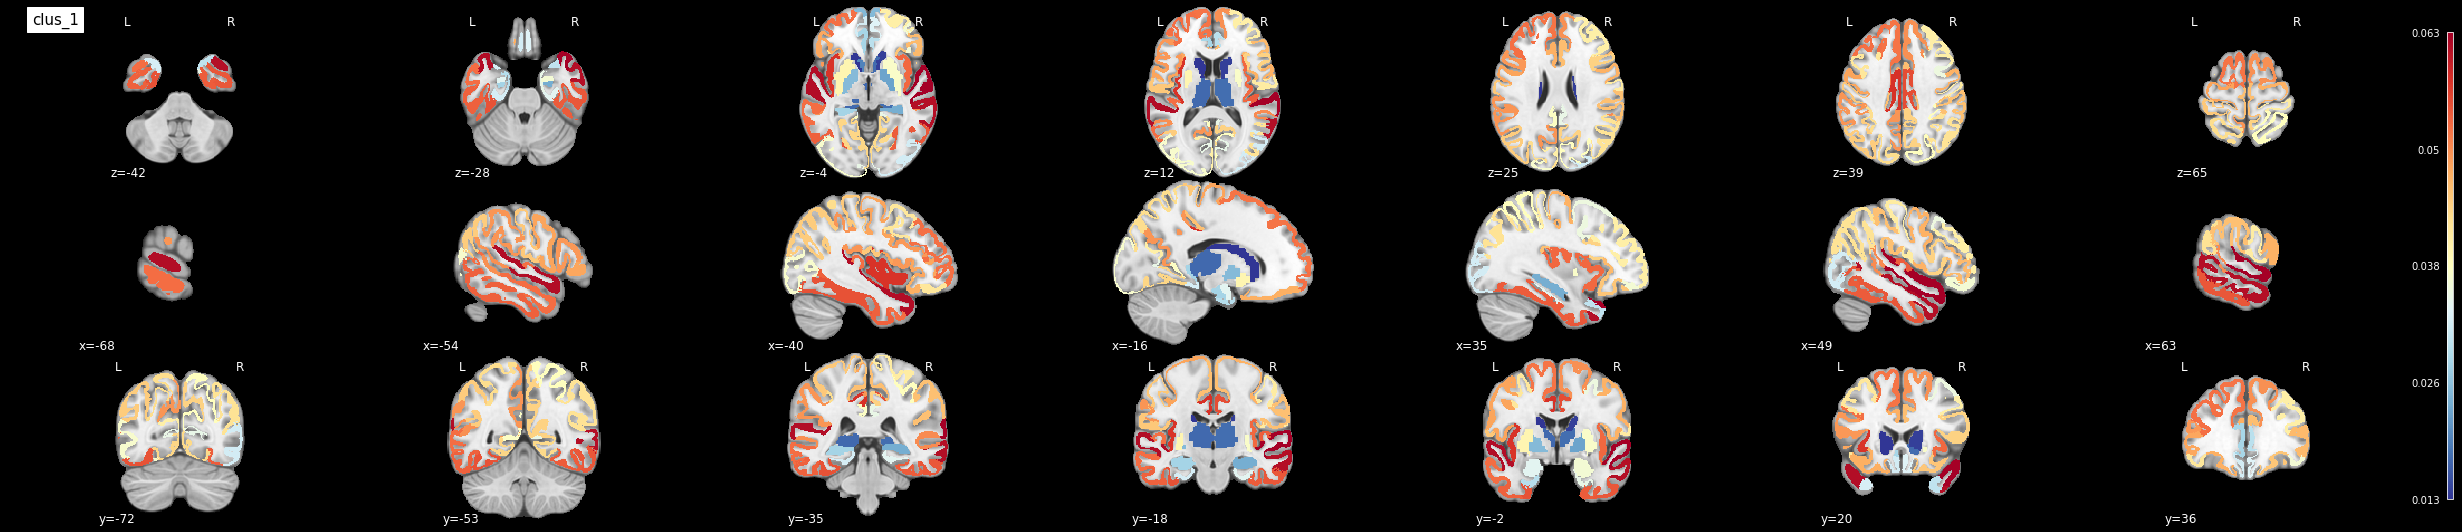

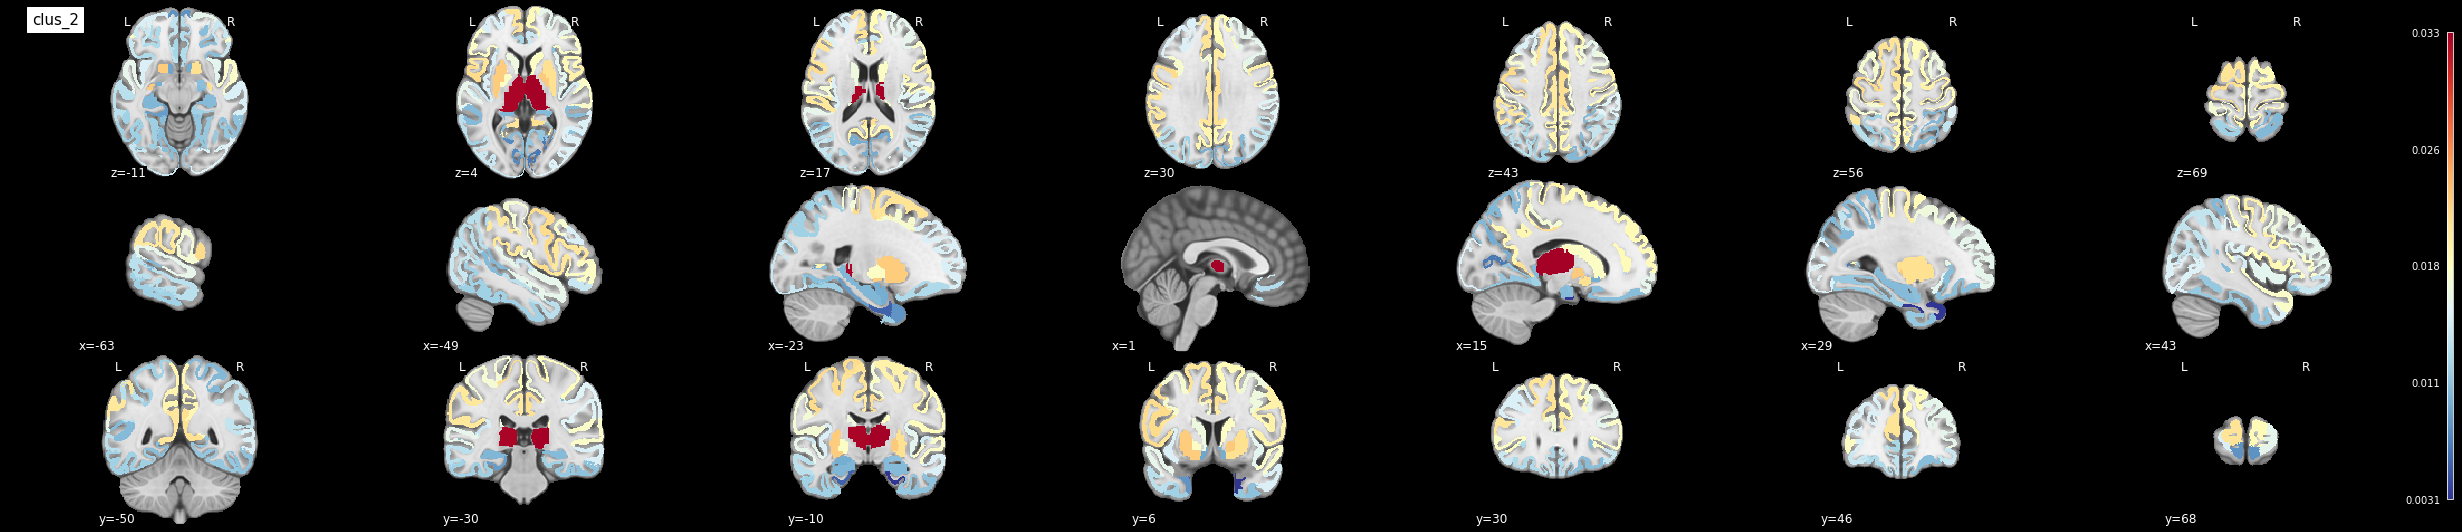

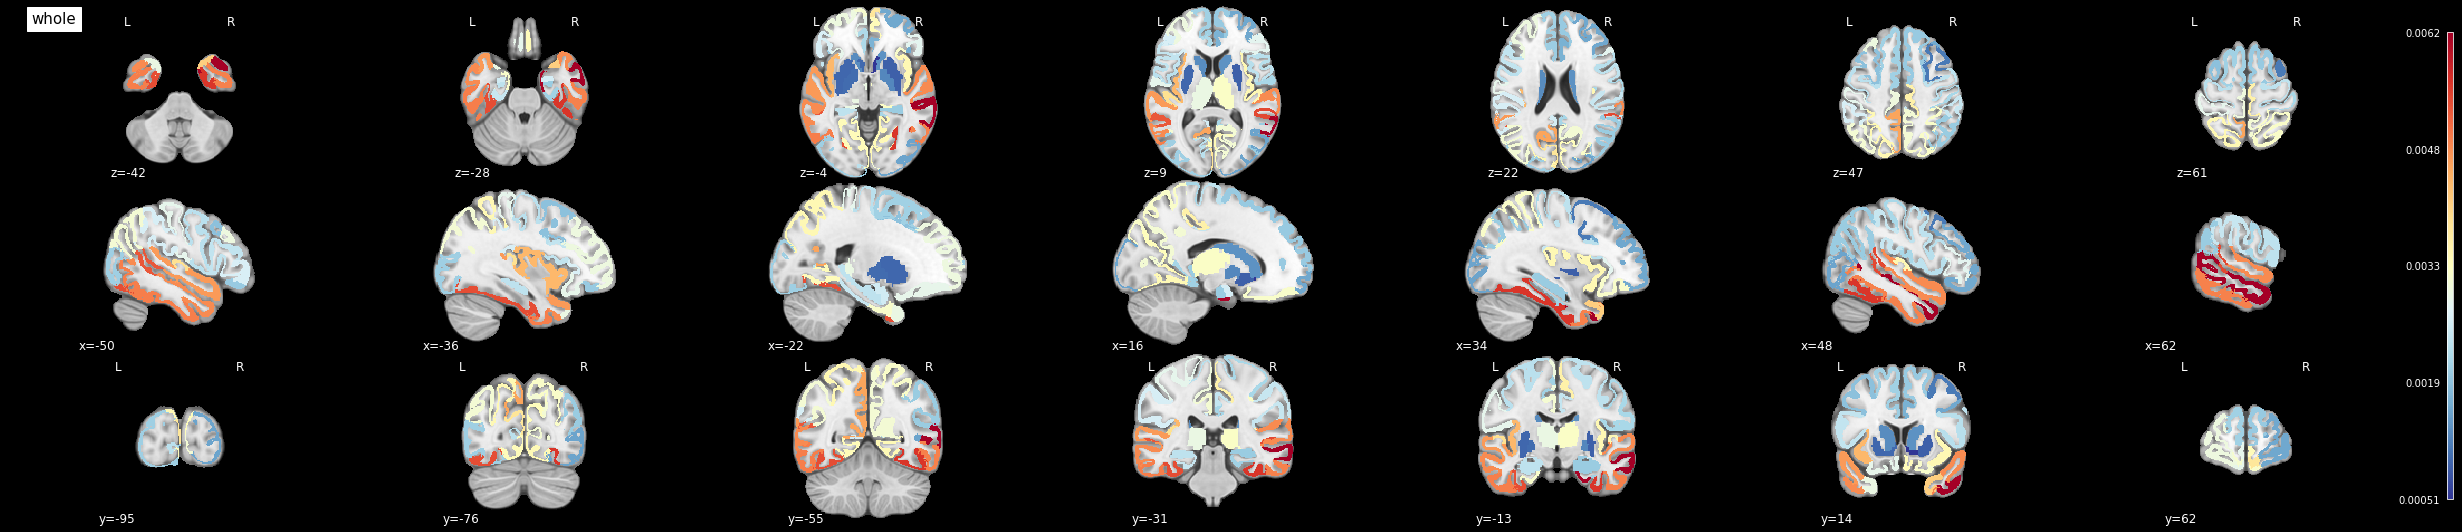

In [8]:
%matplotlib inline
for ii in range(3):
    data = np.zeros_like(atlas_img.get_fdata())
    for jj in range(n_rois):
        data[atlas_img.get_fdata()==(jj+1)] = res_Rsq_df_euclidean.iloc[:, ii].values[jj]
    
    stat_img = image.new_img_like(atlas_img, data)
    plotting.plot_img(stat_img, 
                      colorbar=True,
                      threshold=1e-6,
                      display_mode="mosaic",
                      cmap=plt.cm.RdYlBu_r,
                      bg_img = template_img,
                      draw_cross=False, 
                      black_bg=True,
                      title=res_Rsq_df_euclidean.columns[ii])

Save results to disk for their later use with transcriptomics

In [12]:
res_F_df_euclidean.to_csv("../results/desikan/mdmr_stats_euclidean_desikan.csv.csv", index=False)
res_Rsq_df_euclidean.to_csv("../results/desikan/mdmr_rsquare_euclidean_desikan.csv", index=False)

### Check: 
that our in-house MDMR implementation gives the same as using MDMR package from R

In [ ]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
ro.numpy2ri.activate() 
R = ro.r
R('library(MDMR)')

var_interest = "clus_id_euclidean"
res_Rsq_df_euclidean_rpy2 = pd.DataFrame({})

X_df = XX_df.loc[:, [var_interest] + covariates].copy()
n_clusters = len(pd.to_numeric(X_df.loc[:, var_interest], errors='coerce').dropna().unique())
print(pd.to_numeric(X_df.loc[:, var_interest], errors='coerce').dropna().value_counts())

for jj in [1, 2]:
    print("doing cluster %d" % jj)
    list_Rs_rpy2 = []
    cond = (X_df.clus_id_euclidean =='0') | (X_df.clus_id_euclidean ==str(jj))
    
    XX = X_df.loc[cond,:]
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(XX)
    R.assign('r_from_pd_df', r_from_pd_df)
    R('Xm <- model.matrix(~., data=r_from_pd_df)')
    
    for ii in range(YY.shape[1]):
            mask = np.arange(n_rois)!=ii
            D = squareform(pdist(YY[cond, ii, :][:, mask], 'euclidean'))
            R.assign('D', D)    
            
            list_Rs_rpy2.append(np.asarray(R('as.vector(mdmr(Xm, D, perm.p=FALSE)$pr.sq)'))[1][0])
    res_Rsq_df_euclidean_rpy2['clus_' + str(jj)] = list_Rs_rpy2
    
# Adding whole-group case
X_df =  XX_df.loc[:, ["DX_GROUP"] + covariates].copy()
XX = X_df.copy()
print("doing whole group-case")
list_Rs_rpy2 = []
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(XX)
R.assign('r_from_pd_df', r_from_pd_df)
R('Xm <- model.matrix(~., data=r_from_pd_df)')

for ii in range(YY.shape[1]):
        mask = np.arange(n_rois)!=ii
        D = squareform(pdist(YY[:, ii, :][:, mask], 'euclidean'))
        R.assign('D', D)    

        list_Rs_rpy2.append(np.asarray(R('as.vector(mdmr(Xm, D, perm.p=FALSE)$pr.sq)'))[1][0])
res_Rsq_df_euclidean_rpy2['whole'] = list_Rs_rpy2
    
print("For subtype 1, correlation between MDMR maps using our implementation and R", 
      np.corrcoef(res_Rsq_df_euclidean.clus_1.to_numpy(), res_Rsq_df_euclidean_rpy2.clus_1.to_numpy())[0,1])
print("For subtype 2, correlation between MDMR maps using our implementation and R", 
      np.corrcoef(res_Rsq_df_euclidean.clus_2.to_numpy(), res_Rsq_df_euclidean_rpy2.clus_2.to_numpy())[0,1])
print("For the full ASD, correlation between MDMR maps using our implementation and R", 
      np.corrcoef(res_Rsq_df_euclidean.whole.to_numpy(), res_Rsq_df_euclidean_rpy2.whole.to_numpy())[0,1])

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

/home/javi/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


0.0    835
1.0    321
2.0    266
3.0     21
Name: clus_id_euclidean, dtype: int64
doing cluster 1
doing cluster 2


/home/javi/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


doing whole group-case


/home/javi/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
